In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from sklearn.cross_decomposition import PLSRegression

In [3]:
?PLSRegression

In [4]:
import csv
import matplotlib.pyplot as plt

In [5]:
from scipy import stats
from sklearn import linear_model
import random
from random import shuffle

In [6]:
import math
import numpy as np

In [7]:
df_ON_OF = pd.read_csv("ON_OF.txt", sep='\t')

In [8]:
df_YN_ON = pd.read_csv("YN_ON.txt", sep='\t')

In [9]:
df_YF_OF = pd.read_csv("YF_OF.txt", sep='\t')

In [10]:
df_YN_YF = pd.read_csv("YN_YF.txt", sep='\t')

In [11]:
df_ON = df_ON_OF[[19,4,6,7,8,9]];

In [12]:
df_OF = df_ON_OF[[19,4,10,11,12,13]]

In [13]:
df_YN = df_YN_ON[[19,4,6,7,8,9]]

In [14]:
df_YF = df_YN_YF[[19,4,10,11,12,13]]

In [15]:
def drop_dup(d):
    d = d.drop_duplicates(subset='gene', keep='first')
    return d

def merge(d1, d2):
    return pd.merge(d1, d2, how='outer', on=['gene','width'])

def merge2(d1, d2):
    return pd.merge(d1, d2, how='outer', on='gene')

In [16]:
dft = merge(df_ON, df_OF)

In [17]:
dft = merge(dft, df_YN)

In [18]:
dft = merge(dft, df_YF)

In [19]:
dft = drop_dup(dft)

In [20]:
dft.dropna(thresh=(2), axis=0);

In [21]:
dft = dft[pd.notnull(dft).all(axis=1)]

In [22]:
df = dft

In [23]:
state_dict = {'AT2.young.flu.20150416': 'YF', 'AT2.old.naive.20150416': 'ON', 
                 'AT2.old.flu.20150416': 'OF', 'AT2.young.naive.20150416': 'YN'}

In [24]:
def rename_cols(df, state_dict):
    cols = df.columns
    temp_cols = list(cols)
    #print temp_cols
    for c in range(len(cols)):
        state_name = cols[c][:-2]
        #sample_num = cols[c][-2:]
        total_name = cols[c]
        #print state_name
        if state_name in state_dict:
            new_state_name = state_dict[state_name]
            new_col = total_name.replace(state_name, new_state_name)
            temp_cols[c] = new_col
            #print abb_pair_dict[state_name]
    df.columns = temp_cols
    #print temp_cols
    return df
        
    

In [25]:
df = rename_cols(df, state_dict)

In [26]:
len(df)

14285

In [27]:
def df_to_names(df):
    
    name_dict = {}
        
    for i in range(2,len(df.columns)):
        name = df.columns[i][:-2]
        if name in name_dict:
            name_dict[name].append(i)
        else:
            name_dict[name] = [i]
            
    return name_dict

In [28]:
name_dict = df_to_names(df)

In [29]:
def coshuffle(X):
    
    new_X = [[] for i in range(len(X))]
    index_shuf = range(len(X[0]))
    shuffle(index_shuf)
    print index_shuf[:10]
    for i in range(len(X)):
        origX = X[i]
        for s in index_shuf:
            new_X[i].append(X[i][s])

    return new_X

In [30]:
gene_list = np.array(df['gene'])
gene_dict = {i: gene_list[i] for i in range(len(gene_list))}

In [31]:
xt = np.array(df.ix[:,range(2,18)])

In [32]:
def cycle_cols(X):
    Qs = []
    for i in range(500):#len(X)):
        y = np.array(df.ix[:,range(10,14)])[i]
        ir = [ii for ii in range(len(X)) if ii != i]
        Xt = np.array(df.ix[:,range(10,14)])[ir]
        X = Xt.transpose()
        Qs.append(calc_Q2(X, y, n_pcs = 2))
    return Qs

In [69]:
def vipp(x, y, t, w):

    """
    From original MATLAB code
    See https://code.google.com/p/carspls/

    #+++ vip=vipp(x,y,t,w);
    #+++ t: scores, which can be obtained by pls_nipals.m
    #+++ w: weight, which can be obtained by pls_nipals.m
    #+++ to calculate the vip for each variable to the response;
    #+++ vip=sqrt(p*q/s);
    """
    #initializing
    [p, h] = w.shape
    co = np.matrix(np.zeros([1, h]))

    # Calculate s
    for ii in range(h):
        corr = np.corrcoef(y, t[:, ii], rowvar=0)
        co[0, ii] = corr[0, 1]**2
    s = np.sum(co)

    # Calculate q
    # This has been linearized to replace the original nested for loop
    w_power = np.power(w, 2)
    d = np.multiply(w_power, co)
    q = np.sum(d, 1)
    vip = np.sqrt(p*q/s)
    return vip

In [34]:
def calc_acc(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    pls = PLSRegression(n_pcs, scale=False)
    pls.fit(x_matrix, target_y)
    
    for mouse in range(n_mice):
        
        pred.append(pls.predict(x_matrix[mouse]))
        vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)
    
    error1 = 0
    error2 = 0
    l2 = int(len(target_y)/2)
    for p in range(len(pred)):
        if p < l2+1:
            error1 += abs(int(pred[p]) - target_y[p])
        else:
            error2 += abs(int(pred[p]) - target_y[p])
    
    return error1, error2

In [70]:
dft = df.ix[:,[2,3,4,5,6,7,8,9]].transpose()

In [106]:
on_of = range(2,10)
yn_on = [10,11,12,13,2,3,4,5]
yn_yf = [10,11,12,13,14,15,16,17] 
data = [on_of, yn_on, yn_yf]
new_data = []
#mouse_ind = [2,3,4,5,10,11,12,14]
for d in data:
    print d
    dft = df.ix[:,d].transpose()
    for i in dft:
        di = dft[i]
        dft[i] = dft[i].apply(lambda x: (x - di.mean())/ (di.max() - di.min()))
    new_data.append(dft.transpose())

[2, 3, 4, 5, 6, 7, 8, 9]
[10, 11, 12, 13, 2, 3, 4, 5]
[10, 11, 12, 13, 14, 15, 16, 17]


In [146]:
new_data[0]

,ON.1,ON.2,ON.3,ON.4,OF.1,OF.2,OF.3,OF.4
0,0.494601,-0.448323,-0.505399,0.245652,-0.455412,0.197921,0.370422,0.100537
1,0.520413,-0.252405,0.144357,0.201657,0.192721,-0.479587,-0.349826,0.022670
3,0.591321,0.290648,-0.038835,0.480848,-0.317688,-0.396702,-0.408679,-0.200914
4,0.119134,0.139441,0.420199,0.107866,-0.019723,-0.096185,-0.090931,-0.579801
5,-0.078723,-0.350479,-0.191847,-0.131294,-0.280848,-0.014433,0.649521,0.398103
6,-0.482975,-0.518886,-0.512930,-0.158107,0.402966,0.429896,0.358921,0.481114
7,0.156763,-0.532977,-0.454913,-0.222586,0.096683,0.166159,0.323847,0.467023
8,-0.285535,0.176772,0.588483,0.031965,0.318853,-0.411517,-0.014828,-0.404194
9,-0.301996,0.506059,0.414687,-0.493941,0.475503,0.200135,-0.362739,-0.437708
10,-0.362978,0.012621,-0.195666,-0.115248,0.108469,-0.143859,0.059640,0.637022


In [163]:
target_y = np.array([0,0,0,0,1,1,1,1])
x_matrix = np.array(dft)
pls = PLSRegression(3, scale=False)
pls.fit(x_matrix, target_y)
vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)

In [139]:
target_y = np.array([0,0,0,0,1,1,1,1])
x_matrix = np.array(df.ix[:,[2,3,4,5,6,7,8,9]]).transpose()
pls = PLSRegression(3, scale=False)
pls.fit(x_matrix, target_y)
vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)

In [155]:
vips = []
for d in new_data:
    target_y = np.array([0,0,0,0,1,1,1,1])
    x_matrix = np.array(d).transpose()
    pls = PLSRegression(3, scale=False)
    pls.fit(x_matrix, target_y)
    vips.append(vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_))

In [166]:
vips

matrix([[ 0.29116821],
        [ 0.8105367 ],
        [ 1.22456041],
        ..., 
        [ 0.43152315],
        [ 0.18184597],
        [ 1.57565585]])

In [157]:
vips

[matrix([[ 0.38132568],
         [ 0.81902217],
         [ 1.73888412],
         ..., 
         [ 0.06450967],
         [ 0.36824579],
         [ 1.56174731]]), matrix([[ 1.35496153],
         [ 0.82383883],
         [ 0.86895445],
         ..., 
         [ 1.17148416],
         [ 1.54852124],
         [ 0.84624899]]), matrix([[ 0.29116821],
         [ 0.8105367 ],
         [ 1.22456041],
         ..., 
         [ 0.43152315],
         [ 0.18184597],
         [ 1.57565585]])]

In [161]:
def list_vip_genes(vips):
    for i, v in enumerate(vips):
        if v > 2:
            print i, gene_dict[i], v[0]

In [162]:
#for i, v in enumerate(vips[0][:10]):
 #   print i 
for vs in vips:
    #print vs
    list_vip_genes(vs)

5 Scmh1 [[ 2.19696184]]
134 Lgals9 [[ 2.23516766]]
195 Itga3 [[ 2.11109805]]
280 Psmc3 [[ 2.20090907]]
311 Irf9 [[ 2.32266018]]
398 Relb [[ 2.05026586]]
453 Rabac1 [[ 2.03597804]]
662 Mcm5 [[ 2.01971965]]
678 Fcer2a [[ 2.20854677]]
689 Psmd4 [[ 2.26495585]]
706 Psmb4 [[ 2.1208276]]
774 Ggt5 [[ 2.16089913]]
838 Sod2 [[ 2.01697582]]
848 Vars [[ 2.03270477]]
927 Mgst1 [[ 2.16079671]]
978 Apobec3 [[ 2.01898958]]
1047 Slc5a1 [[ 2.08249114]]
1082 Steap4 [[ 2.01671451]]
1121 St3gal1 [[ 2.00223858]]
1161 Camta1 [[ 2.04266465]]
1264 Capza2 [[ 2.00140851]]
1308 H2-M3 [[ 2.3026869]]
1355 Slpi [[ 2.08285698]]
1483 Gid4 [[ 2.29442898]]
1583 Isyna1 [[ 2.2370621]]
1625 Arid3a [[ 2.03920182]]
1787 Ppa1 [[ 2.02746569]]
1803 Tbk1 [[ 2.11662162]]
1843 Csrp2 [[ 2.09979144]]
1918 Hnrnpab [[ 2.00948303]]
2065 Slc26a4 [[ 2.19647048]]
2322 Net1 [[ 2.20510139]]
2335 Npc2 [[ 2.19846926]]
2572 Sftpd [[ 2.13203691]]
2597 Pnp [[ 2.01825725]]
2620 Itih4 [[ 2.05216344]]
2627 Ctsb [[ 2.14677555]]
2674 Clu [[ 2.129764

In [ ]:
for vs in vipsort

In [167]:
vipsort = [np.sort(v, axis=0)[::-1] for v in vips]

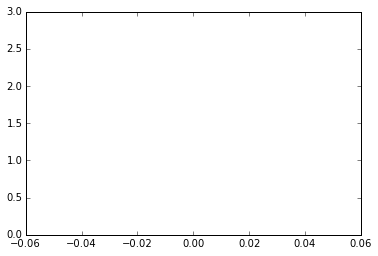

In [168]:
for vs in vipsort:
    plt.plot(vs[:100])

In [120]:
for vs in vips:
    list_vip_genes(vs)

In [140]:
list_vip_genes(vips)

2567 Sftpa1 [[ 3.7879346]]
2692 Sftpc [[ 63.28714029]]
2929 Ly6e [[ 11.50700955]]
3545 Scgb1a1 [[ 22.25583567]]
3550 Fth1 [[ 3.47181988]]
3756 Cbr2 [[ 14.0375707]]
3899 Ifitm3 [[ 6.73409695]]
4433 Lcn2 [[ 14.04581727]]
7988 Scd1 [[ 3.279586]]
7993 Lrg1 [[ 9.42206507]]
11606 B2m [[ 6.25970664]]
11641 H2-K1 [[ 12.07055567]]
11927 Chi3l1 [[ 8.9887059]]
11941 mt-Rnr1 [[ 3.23896242]]
11942 mt-Rnr2 [[ 3.28087892]]
11943 mt-Nd1 [[ 25.67887459]]
11946 mt-Nd2 [[ 28.83216112]]
11952 mt-Co1 [[ 47.10907039]]
11954 mt-Atp8 [[ 8.37282]]
11958 mt-Nd4 [[ 24.14899182]]
11959 mt-Nd5 [[ 22.52249695]]
11960 mt-Nd6 [[ 20.90295849]]
11961 mt-Te [[ 11.34037877]]
11962 mt-Cytb [[ 49.88545183]]
12168 Lyz2 [[ 15.34408424]]
12434 H2-D1 [[ 7.99493105]]
12692 Gm23935 [[ 14.92991116]]
12700 Igkc [[ 6.84117344]]
12802 Ifi27l2a [[ 6.83857508]]
14255 Gm26924 [[ 8.16594868]]


In [76]:
list_vip_genes(vips)

2692 Sftpc [[ 63.28714029]]
2929 Ly6e [[ 11.50700955]]
3545 Scgb1a1 [[ 22.25583567]]
3756 Cbr2 [[ 14.0375707]]
4433 Lcn2 [[ 14.04581727]]
11641 H2-K1 [[ 12.07055567]]
11943 mt-Nd1 [[ 25.67887459]]
11946 mt-Nd2 [[ 28.83216112]]
11952 mt-Co1 [[ 47.10907039]]
11958 mt-Nd4 [[ 24.14899182]]
11959 mt-Nd5 [[ 22.52249695]]
11960 mt-Nd6 [[ 20.90295849]]
11961 mt-Te [[ 11.34037877]]
11962 mt-Cytb [[ 49.88545183]]
12168 Lyz2 [[ 15.34408424]]
12692 Gm23935 [[ 14.92991116]]


In [47]:
list_vip_genes(vips)

2692 Sftpc [[ 66.95941976]]
3545 Scgb1a1 [[ 15.56251064]]
3756 Cbr2 [[ 11.71310801]]
4433 Lcn2 [[ 13.83918241]]
11641 H2-K1 [[ 10.73469854]]
11943 mt-Nd1 [[ 25.06349453]]
11946 mt-Nd2 [[ 30.31934349]]
11952 mt-Co1 [[ 49.6270573]]
11958 mt-Nd4 [[ 20.40794689]]
11959 mt-Nd5 [[ 22.57524502]]
11960 mt-Nd6 [[ 20.51030461]]
11961 mt-Te [[ 12.14029985]]
11962 mt-Cytb [[ 51.66142831]]
12692 Gm23935 [[ 14.10414617]]


In [137]:
vips = np.sort(vips, axis=0)[::-1]

In [138]:
vips

matrix([[ 2.56422045],
        [ 2.56405138],
        [ 2.52237746],
        ..., 
        [ 0.0159455 ],
        [ 0.013532  ],
        [ 0.0124052 ]])

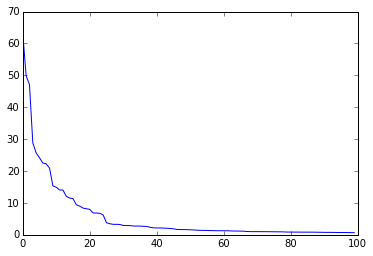

In [79]:
plt.plot(vips[:100])

In [315]:
def calc_Q2(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    for mouse in range(n_mice):
        mice_ind = range(n_mice)
        loo_mouse = x_matrix[mouse]
        mice_ind.remove(mouse)
        x_matrix_t = x_matrix[(mice_ind)]
        target_y_t = target_y[(mice_ind)]
        pls = PLSRegression(n_pcs, scale=False)
        #print x_matrix
        #print target_y
        pls.fit(x_matrix_t, target_y_t)
        
        pred.append(pls.predict(loo_mouse))
        vips = vipp(x_matrix_t, target_y_t, pls.x_scores_, pls.x_weights_)
    
    num = 0
    den = 0
    for p in range(len(pred)):
        num += ((pred[p] - target_y[p])**2)
        den += ((target_y[p] - np.mean(target_y))**2)
    Q2 = float(1- num/den)
    
    return Q2

In [327]:
def calc_R2(x_matrix, target_y, n_pcs):
    n_mice = len(x_matrix)
    pred = []
    
    pls = PLSRegression(n_pcs, scale=False)
    pls.fit(x_matrix, target_y)
    
    for mouse in range(n_mice):
        
        pred.append(pls.predict(x_matrix[mouse]))
        vips = vipp(x_matrix, target_y, pls.x_scores_, pls.x_weights_)
    
    num = 0
    den = 0
    for p in range(len(pred)):
        num += ((pred[p] - target_y[p])**2)
        den += ((target_y[p] - np.mean(target_y))**2)
    R2 = float(1- num/den)
    
    return R2

In [445]:
Q2 = calc_Q2(x_matrix, target_y, n_pcs=2)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [446]:
Q2

0.31957600882414383

In [389]:
R2 = calc_R2(x_matrix, target_y, n_pcs=2)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [390]:
R2

0.9044349533854793

In [391]:
np.mean(target_y)

0.5

In [185]:
for mat in x_matrix:
    pls.predict(mat)

/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/Users/tjyacoub/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a si

In [172]:
vipsa = np.array(vips)

In [ ]:
pls.predict

In [173]:
vipsa

array([[ 0.0172812 ],
       [ 0.00054983],
       [ 0.0057373 ],
       ..., 
       [ 0.50083962],
       [ 0.00670487],
       [ 0.0073769 ]])

In [174]:
gene_list[11923:11982]

array(['Rab3ip', '4430402I18Rik', 'Ano6', 'Ifi27', 'Chi3l1', 'Plcxd1',
       'Ethe1', 'Gimap8', 'Zfp428', 'Hvcn1', 'Ccdc146', 'Cdpf1', 'Tank',
       'Aox3', 'Clasp1', 'Lrrc51', 'Hhip', 'Siva1', 'mt-Rnr1', 'mt-Rnr2',
       'mt-Nd1', 'mt-Ti', 'mt-Tq', 'mt-Nd2', 'mt-Tw', 'mt-Ta', 'mt-Tn',
       'mt-Tc', 'mt-Ty', 'mt-Co1', 'mt-Co2', 'mt-Atp8', 'mt-Atp6',
       'mt-Co3', 'mt-Nd3', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Te',
       'mt-Cytb', 'mt-Tt', 'mt-Tp', 'Sepp1', 'Rn7sk', 'Tacc1', 'Cpped1',
       'Aurkaip1', 'Dhrs3', 'Ubr4', 'Hnrnpr', 'Med18', 'Phactr4', 'Gm1976',
       'Muc5b', 'Adamtsl1', 'Kndc1', 'Prpf4', 'Cdc26', 'Slc31a1'], dtype=object)

2567 Sftpa1 [ 6.86361807]
2692 Sftpc [ 31.50918461]
2929 Ly6e [ 7.5887478]
3545 Scgb1a1 [ 39.15060487]
3550 Fth1 [ 6.02429228]
3756 Cbr2 [ 11.60840071]
3899 Ifitm3 [ 6.95634905]
4433 Lcn2 [ 11.44027598]
7988 Scd1 [ 15.76313038]
7993 Lrg1 [ 5.78466107]
11641 H2-K1 [ 9.18809931]
11927 Chi3l1 [ 7.13842117]
11943 mt-Nd1 [ 48.44249341]
11946 mt-Nd2 [ 20.82840118]
11952 mt-Co1 [ 31.95517667]
11954 mt-Atp8 [ 7.07148034]
11958 mt-Nd4 [ 21.46852349]
11959 mt-Nd5 [ 20.94123694]
11960 mt-Nd6 [ 17.9249754]
11961 mt-Te [ 23.72988147]
11962 mt-Cytb [ 59.85328262]
12167 Lyz1 [ 5.9551361]
12168 Lyz2 [ 14.96629672]
12434 H2-D1 [ 5.59088668]
12692 Gm23935 [ 21.93518974]
12700 Igkc [ 14.74442488]
12802 Ifi27l2a [ 5.61543903]
13828 Igha [ 7.74019115]
14255 Gm26924 [ 13.08865958]


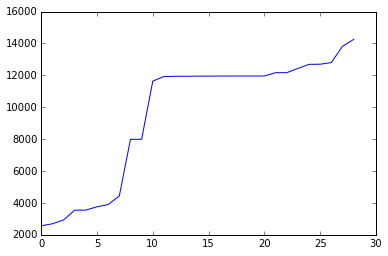

In [175]:
ti = []
for i in range(len(vipsa)):
    if vipsa[i] > 5:
        #print i
        print i, gene_dict[i], vipsa[i]
        ti.append(i)
plt.plot(ti)

In [67]:
vipdf = pd.DataFrame(np.sort(vips, axis=0))

In [69]:
vipsort = vipdf.columns[::-1]

In [70]:
vipsort

Int64Index([0], dtype='int64')

In [28]:
def unique(a, b):
    return list([a[i] for i in range(1,len(a)) if a[i] not in b])
def intersect(a, b):
    return list(set(a) & set(b))
def union(a, b):
    return list(set(a) | set(b))
def intersect3(a, b, c):
    return list(set(a) & set(b) & set(c))

def unique3(a, b, c, index):
    uniques = [0 for i in range(3)]
    uniques[0] = list([a[i] for i in range(1,len(a)) if a[i] not in b and a[i] not in c])
    uniques[1] = list([b[i] for i in range(1,len(b)) if b[i] not in a and b[i] not in c])
    uniques[2] = list([c[i] for i in range(1,len(c)) if c[i] not in a and c[i] not in b])
    return uniques[index]
